In [1430]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.cluster import AgglomerativeClustering

In [1431]:
#load data
restaurants = pd.read_csv('restaurants.csv')
test_set = pd.read_csv('test_set.csv')
transactions = pd.read_csv('transactions.csv')
user_stats = pd.read_csv('user_stats.csv')

#Problem Definition

> LMWN want benefit from stauts purchase by identifying which customers are likely to make a purchase and when. LMWN have the data on transacions, restaurant detail and user status.The goal of this project is to build a model that can accurately predict a customer's purchase status (i.e. whether they will make a purchase or not) based on their past behavior information.This will allow LMWN to target marketing efforts more effectively and increase the likelihood of use the app services. 



# EDA

In [1432]:
transactions.info() 
#transactions[transactions['discount_amount'] == 0] # 129339 from 139095 that not have discount

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139095 entries, 0 to 139094
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    139095 non-null  object 
 1   created_at        139095 non-null  object 
 2   dt                139095 non-null  int64  
 3   user_id           139095 non-null  object 
 4   restaurant_id     139095 non-null  object 
 5   status            139095 non-null  object 
 6   distance          139095 non-null  float64
 7   final_food_price  139095 non-null  float64
 8   discount_amount   10387 non-null   float64
 9   completed_at      123490 non-null  object 
 10  delivery_fee      139095 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 11.7+ MB


In [1433]:
# transactions 139095 rows, 11 columns
transactions['status'][transactions['status'] != 'COMPLETED'] = 0
transactions['status'][transactions['status'] == 'COMPLETED'] = 1
transactions.describe() 

<ipython-input-1433-96cc9b866d2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['status'][transactions['status'] != 'COMPLETED'] = 0
<ipython-input-1433-96cc9b866d2d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['status'][transactions['status'] == 'COMPLETED'] = 1


,dt,distance,final_food_price,discount_amount,delivery_fee
count,1.390950e+05,139095.000000,139095.000000,10387.000000,139095.000000
mean,2.021022e+07,3372.372842,108.326757,52.639232,4.239300
std,8.189590e+01,2089.373671,89.927964,29.434587,11.517421
min,2.021010e+07,0.000000,0.000000,0.000000,0.000000
25%,2.021012e+07,1818.000000,60.000000,37.000000,0.000000
50%,2.021022e+07,2990.000000,80.000000,50.000000,0.000000
75%,2.021031e+07,4632.000000,125.000000,70.000000,1.000000
max,2.021032e+07,30201.000000,3580.000000,999.000000,237.000000


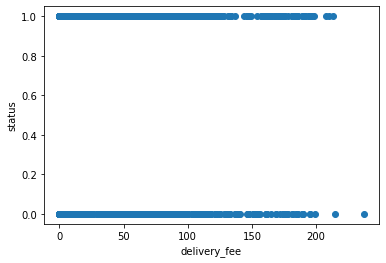

Complete : 123490
Cancle : 15605
In this section we can say that the delivery_fee is not significant to indicate that customers will make complete order or not.
Other way it can say that the delivery_fee price not possible to tell that high delivery fee customers will cancle or low customer will purchase
generally it depends on customers at that time which decide to purchase or not So delivery_fee will not include in the model.
Most of delivery fee is vary around 0 - 200 bath.


In [1434]:
plt.scatter(transactions['delivery_fee'],transactions['status'])
plt.xlabel('delivery_fee')
plt.ylabel('status')
plt.show()
print(f"Complete : {len(transactions[transactions['status'] == 1])}")
print(f"Cancle : {len(transactions[transactions['status'] == 0])}")
print("In this section we can say that the delivery_fee is not significant to indicate that customers will make complete order or not.\nOther way it can say that the delivery_fee price not possible to tell that high delivery fee customers will cancle or low customer will purchase\ngenerally it depends on customers at that time which decide to purchase or not So delivery_fee will not include in the model.\nMost of delivery fee is vary around 0 - 200 bath.")

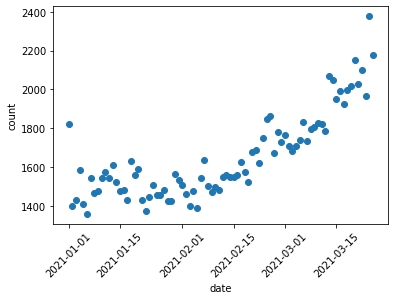

In [1435]:
transactions['created_at'] = pd.to_datetime(transactions['created_at'])
transactions['date'] = transactions['created_at'].dt.date
count = transactions['date'].value_counts().to_frame().reset_index()
count.rename(columns={'index':'date','date': 'count'}, inplace=True)

plt.scatter(count['date'], count['count'])
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('count')
plt.show()
print("")

In [1436]:
transactions['diff_time'] = pd.to_datetime(transactions['completed_at']) - pd.to_datetime(transactions['created_at'])
mask = transactions['diff_time'].isnull()
transactions.loc[mask, 'diff_time'] = pd.Timedelta(0)
a = transactions['diff_time'].value_counts().to_frame().reset_index()
#print(transactions[transactions['diff_time'] < pd.Timedelta(minutes=1)])
#print((transactions['status'][transactions['diff_time'] >= pd.Timedelta(minutes=1)]).value_counts())
#print(transactions['status'].value_counts())

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


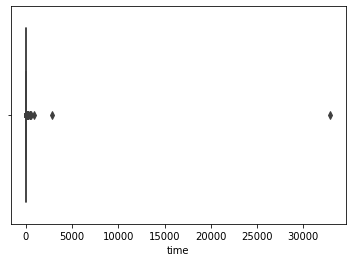

from the chart there is the complete time that more than 30000 min. so it could be outlier for sure.
And from the regular waiting time I ever met that have long waiting time it will be the overnight orders so it shouldn't more than 1000 min or 16 hours.
So if I found the time that exceed 16 hour. I will remove it for sure


In [1437]:
sns.boxplot((transactions['diff_time'].dt.total_seconds())/60)
plt.xlabel('time')
plt.show()
print("from the chart there is the complete time that more than 30000 min. so it could be outlier for sure.\nAnd from the regular waiting time I ever met that have long waiting time it will be the overnight orders so it shouldn't more than 1000 min or 16 hours.\nSo if I found the time that exceed 16 hour. I will remove it for sure")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


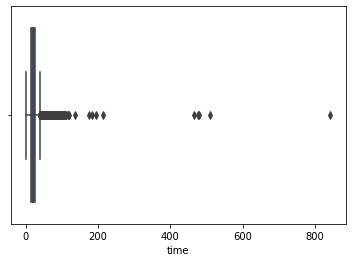

So it look better now for use in model section.


In [1438]:
transactions = transactions.drop(transactions[transactions['diff_time'] > "0 days 16:00:00"].index)
sns.boxplot((transactions['diff_time'].dt.total_seconds())/60)
plt.xlabel('time')
plt.show()
print("So it look better now for use in model section.")

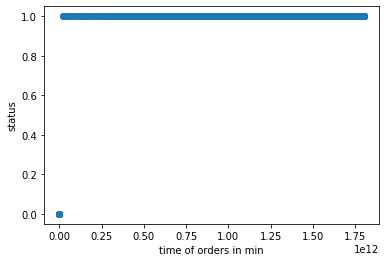

Number of order that customers wait less than 30 min is: 124090 that is the most of purchase order in transactions


In [1439]:
data = transactions[transactions['diff_time'] <= "0 days 00:30:00"]
plt.scatter(data['diff_time'], data['status'])
plt.xlabel('time of orders in min')
plt.ylabel('status')
plt.show()
c = len(transactions['diff_time'][transactions['diff_time'] <= "0 days 00:30:00"])
print(f"Number of order that customers wait less than 30 min is: {c} that is the most of purchase order in transactions")

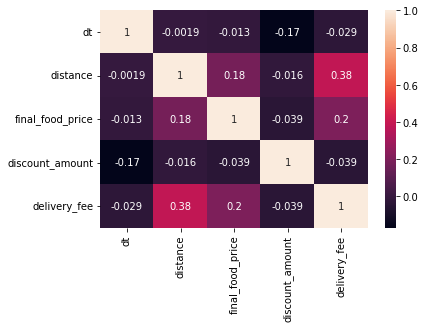

from heatmap we can see that 
-distance correlate to delivery_fee
-distance correlate to final_food_price
-final_food_price correlate to delivery_fee 


In [1440]:
df_heat = transactions.corr()
sns.heatmap(df_heat, annot=True)
plt.show()
print("from heatmap we can see that \n-distance correlate to delivery_fee\n-distance correlate to final_food_price\n-final_food_price correlate to delivery_fee ")

# Data Wrangling
## change format of data that suit to use in model, delete some feature or add some feature
## group by the duplicate of user_id by "mean", represent to all duplicate rows in data set.

In [1441]:
#drop feature that we definitely don't use
transactions_cut = transactions.drop(['transaction_id','created_at','dt','restaurant_id','completed_at','diff_time'],axis=1)
transactions_melt = transactions_cut.melt(id_vars = ['user_id','date','distance','final_food_price','discount_amount','delivery_fee'], var_name = 'status',value_name='value')
transactions_melt['date'] = pd.to_datetime(transactions_melt['date'])
transactions_melt = transactions_melt.drop('status',axis = 1)

# change long format to wide format to use in model
transactions_melt = transactions_melt.reset_index()
#transaction_wide = transactions_melt.pivot_table(index=['index','user_id','distance','final_food_price','discount_amount','delivery_fee'], columns = 'date',values = 'value',aggfunc='sum')
transaction_wide = transactions_melt.pivot(index=['index','user_id','distance','final_food_price','discount_amount','delivery_fee'], columns = 'date',values = 'value')

#fill missing value with 0
transaction_wide = transaction_wide.fillna(0)
transaction_wide.sort_values(by='user_id', inplace=True)
transaction_wide = transaction_wide.reset_index()
#transaction_wide['user_id'][transaction_wide.iloc[:,2] == 1]
transaction_wide['discount_amount'][transaction_wide['discount_amount'].isnull()] = 0

#group_by the user_id for easy in model prediction
transaction_wide = transaction_wide.groupby('user_id').mean().reset_index()
transaction_wide

<ipython-input-1441-5a85629b4dd7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_wide['discount_amount'][transaction_wide['discount_amount'].isnull()] = 0


date,user_id,index,distance,final_food_price,discount_amount,delivery_fee,2021-01-01 00:00:00,2021-01-02 00:00:00,2021-01-03 00:00:00,2021-01-04 00:00:00,...,2021-03-16 00:00:00,2021-03-17 00:00:00,2021-03-18 00:00:00,2021-03-19 00:00:00,2021-03-20 00:00:00,2021-03-21 00:00:00,2021-03-22 00:00:00,2021-03-23 00:00:00,2021-03-24 00:00:00,2021-03-25 00:00:00
0,user_0,41290.000000,1081.000000,50.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,user_1,85369.000000,3445.000000,94.000000,94.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,user_10,83370.600000,2259.786667,83.533333,0.0,0.666667,0.0,0.0,0.0,0.133333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,user_100,77373.000000,3720.571429,115.000000,0.0,17.142857,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,user_1000,33073.000000,23795.800000,375.000000,0.0,185.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22752,user_9995,81772.000000,3257.000000,156.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22753,user_9996,67840.250000,2692.400000,205.500000,0.0,0.000000,0.0,0.5,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22754,user_9997,67104.000000,2233.000000,65.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22755,user_9998,112828.000000,2153.000000,110.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineer

## forecast 3 day: I will use the data from 2021-01-01 to 2021-03-25 and furture more to predict 2021-03-26,  2021-03-27 and 2021-03-28 


In [1442]:
#separate the date into 3 group for 3 target variable prediction with random
random.seed(11)
numbers = [i for i in range(7,len(transaction_wide.columns))]

num_lists = 3

list_size = len(numbers) // num_lists

split_lists = [[] for _ in range(num_lists)]

random.shuffle(numbers)

for i, number in enumerate(numbers):
    split_lists[i % num_lists].append(number)

print(split_lists)

[[39, 65, 28, 17, 14, 37, 55, 80, 71, 63, 52, 23, 33, 73, 75, 87, 35, 56, 22, 10, 60, 27, 12, 45, 84, 30, 72, 78], [15, 26, 29, 74, 54, 13, 34, 32, 83, 50, 51, 69, 24, 68, 47, 62, 70, 8, 88, 11, 7, 77, 18, 86, 67, 31, 89, 64], [20, 41, 59, 61, 48, 43, 79, 53, 49, 16, 58, 42, 81, 38, 21, 44, 36, 76, 9, 40, 46, 57, 25, 19, 85, 82, 66]]


In [1443]:
regress_of_26 = transaction_wide.iloc[:,[i for i in range(7)] + split_lists[0]]
regress_of_27 = transaction_wide.iloc[:,[i for i in range(7)] + split_lists[1]]
regress_of_28 = transaction_wide.iloc[:,[i for i in range(7)] + split_lists[2]]
data = transaction_wide.drop('index',axis=1)

#regress_of_26['sim_2021-03-26'] = regress_of_26.T.iloc[6:,:].mean()
#regress_of_26['sim_2021-03-26'][regress_of_26['sim_2021-03-26'] > 0] = 1
#regress_of_26

# Model selection is Hierarchical clustering
## we will split into 3 day 26,27,28 and then predict 'pred_2x'

In [1444]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
def encode(df):
    df.reset_index()
    df = df.drop('user_id',axis = 1)
    #df = pd.DataFrame(df).reset_index().rename(columns={'index': 'user_id'})
    return pd.DataFrame(df).reset_index().rename(columns={'index': 'user_id'})

def prep_date(df):
    df = df.iloc[:, [i for i in range(5,len(df.columns))]]
    return df

def prep_pre_process(df):
    scaler = MinMaxScaler()
    df.loc[:,['user_id','distance','final_food_price','discount_amount','delivery_fee']] = scaler.fit_transform(df.loc[:,['user_id','distance','final_food_price','discount_amount','delivery_fee']])
    return df

def prep_pre_process2(df):
    scaler = MinMaxScaler()
    df.loc[:,['distance','final_food_price','discount_amount','delivery_fee']] = scaler.fit_transform(df.loc[:,['distance','final_food_price','discount_amount','delivery_fee']])
    return df


In [1445]:
#Hierarchical clustering with cluster = 2 because it is binary(0,1)
from sklearn.cluster import AgglomerativeClustering
def model(df):
    agg_clustering = AgglomerativeClustering(n_clusters=2)
    clusters = agg_clustering.fit_predict(df)
    return pd.DataFrame(clusters)

In [1446]:
#predict the label of 26,27,28
np.random.seed(11)
data['pred_26'] = model(regress_of_26.drop(['user_id','index'],axis = 1))
data['pred_27'] = model(regress_of_27.drop(['user_id','index'],axis = 1))
data['pred_28'] = model(regress_of_28.drop(['user_id','index'],axis = 1))
print(data['pred_26'].value_counts())
print(data['pred_27'].value_counts())
print(data['pred_28'].value_counts())
data


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'str']. An error will be raised in 1.2.
  warnings.warn(


0    18984
1     3773
Name: pred_26, dtype: int64
0    18524
1     4233
Name: pred_27, dtype: int64
0    16266
1     6491
Name: pred_28, dtype: int64


date,user_id,distance,final_food_price,discount_amount,delivery_fee,2021-01-01 00:00:00,2021-01-02 00:00:00,2021-01-03 00:00:00,2021-01-04 00:00:00,2021-01-05 00:00:00,...,2021-03-19 00:00:00,2021-03-20 00:00:00,2021-03-21 00:00:00,2021-03-22 00:00:00,2021-03-23 00:00:00,2021-03-24 00:00:00,2021-03-25 00:00:00,pred_26,pred_27,pred_28
0,user_0,1081.000000,50.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,user_1,3445.000000,94.000000,94.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,user_10,2259.786667,83.533333,0.0,0.666667,0.0,0.0,0.0,0.133333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,user_100,3720.571429,115.000000,0.0,17.142857,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,user_1000,23795.800000,375.000000,0.0,185.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22752,user_9995,3257.000000,156.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
22753,user_9996,2692.400000,205.500000,0.0,0.000000,0.0,0.5,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
22754,user_9997,2233.000000,65.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
22755,user_9998,2153.000000,110.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


#Model Evaluation with encoding

In [1447]:
# pred_of_3_days = encode(data.loc[:,['user_id','distance','final_food_price','discount_amount','delivery_fee','pred_26','pred_27','pred_28']])
pred_of_3_days = data.loc[:,['distance','final_food_price','discount_amount','delivery_fee','pred_26','pred_27','pred_28']]

In [1448]:
pred_of_3_days['purchase'] = model(prep_pre_process2(pred_of_3_days)) # data.drop('user_id',axis = 1)
test_set['purchase'] = pred_of_3_days['purchase']
pred_of_3_days

date,distance,final_food_price,discount_amount,delivery_fee,pred_26,pred_27,pred_28,purchase
0,0.040312,0.013966,0.000000,0.000000,0,0,0,0
1,0.128468,0.026257,0.522222,0.000000,0,0,0,0
2,0.084270,0.023333,0.000000,0.003175,0,0,0,0
3,0.138744,0.032123,0.000000,0.081633,0,0,0,0
4,0.887373,0.104749,0.000000,0.880952,1,1,1,1
...,...,...,...,...,...,...,...,...
22752,0.121457,0.043575,0.000000,0.000000,0,0,0,0
22753,0.100403,0.057402,0.000000,0.000000,0,0,0,0
22754,0.083271,0.018156,0.000000,0.000000,0,0,0,0
22755,0.080288,0.030726,0.000000,0.000000,0,0,0,0


In [1449]:
print(f"The performance of this model is {np.mean(((pred_of_3_days['pred_26']+pred_of_3_days['pred_27']+pred_of_3_days['pred_28']) > 0) == (pred_of_3_days['purchase'] == 1))} or {np.mean(((pred_of_3_days['pred_26']+pred_of_3_days['pred_27']+pred_of_3_days['pred_28']) > 0) == (pred_of_3_days['purchase'] == 1))*100} %")

The performance of this model is 0.8805642219976271 or 88.05642219976271 %


In [1451]:
#send csv file to the Files field
test_set.to_csv('test_set.csv', index=False)

#Conclusion
##Accroding from data set and seed(11) we can predict our target that is the purchase status on 2021-03-26,2021-03-27 and 2021-03-28 by use all column without user_id and index. Then predict the purchase status column by purchase status on 2021-03-26,2021-03-27 and 2021-03-28 and important feature such as distance, final_food_price in mean term after group by and the mean it can use to represent all duplicate transactions orders that have the same user_id in once. Finally the accuracy of model is run around 50 - 95% of correct predict purchase status. 

# Answer the following Quetions
## The feature that most important that I choose is 
*   1.Date('create_at' in transaction)
*   2.Distance
*   3.Delivery_fee

## **a.1 : How important is this feature?**
##  **Ans :** Date is mainly use to predict the purchase status of 2021-03-26, 2021-03-27 and 2021-03-28. Distance and delivery fee are additional for adjust the prediction and this 2 feature has the statistic correlation between each other but main of feature is still date. The important of these two is adjust the model because if we only use date the data will came out bad information even if change the seed it still get the result similar to previous data.

## **a.2 What does the feature mean/represent? (Explain this in a way that a non-technical audience can understand.)**
## **Ans :** **First** one 'Date' it the most important that will use the predict target labels because it represent to historical data, It can help us to find the pattern of orders and predict the target labels. **Second**, Distance represent to waiting time. It will be the first few thing that customer will consider and decision to purchase or not **Lastly** Delivery fee represent to the cost and will automaticly higher cost according to the distance.

## **a.3 Why did you decide to include this feature in the model?**

## **Ans :** **1.Date** the reason why I should this feature first because it represent to te historical data that we can easy use to forecast future target labels **2.Distance**. Distance is the early selection condition that customers will consider to purchase or not because the long distance lead to the long waiting time and delivery fee. **3.Delivery fee**. The reason that why Delivery fee is the last one because typically most of delivery services app have the thing that call "discount", discount can reduce both the price in food and delivery fee. But why I don't choese the 'discount' in the 3 important feature that because the discount is the rare items that will not recieve every day but the delivery fee will charged you everytime when you purchase the order.
## **Note that:** 1.'Date' that I talking about is the date that change format already and can show detail of each day of transaction orders. 2. The distance and delivery fee is the mean after group by, 'Mean' will use to represent all duplicate of user_id in each orders.

## **b. What are the assumptions made while creating this model?**
## **Ans :** 1.the first assumptions to make it clear is start of date. date will be start on '00:00:00' of each day. 2.group by of user_id that will drop the duplicate of each user_id and summarize by 'mean' that will represent to all duplicate after group by instead 'sum'. from 2 assumption it will make us easies to use the data in modeling section


## **c. What is the expected performance of the model on the test set (that is, the dataset that the model has not been exposed to)?**
## **Ans :** the expected performance of the model is around 50 - 90% of accuracy because it is unsupervised learning that we need to create our output and predict our output again! So I no wonder if the performance of model is low but I wish the least of performance should not less than 50%.

## **d. What kind of data, if available, would improve your model performance?**
## **Ans :** the target feature because now it is unsuperviesd learning model. It hard to perform the model and forecast it. if we have it we can improve it easy than the oldform and increase more accuracy in output feature